refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [41]:
import uproot
import numpy as np
from reco.plotting import plot_event, plot_remapped, plot_tracksters
from reco.evaluation import evaluate
from reco.event import remap_arrays_by_label, remap_items_by_label
from reco.energy import get_total_energy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import awkward as ak
%matplotlib inline

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/Data/multi/new_ntuples_14992862_996.root"


tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

# tracksters.show(name_width=40)

Tracksters reco: 123, tracksters sim: 10
Simulated energy: 3423.19, reconstructed energy: 2886.56 (84.32%)


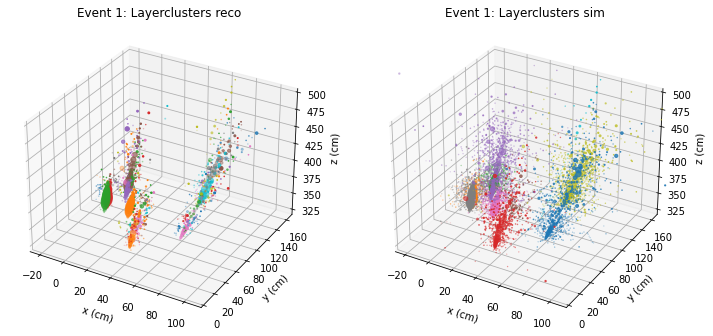

In [42]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [43]:
precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.97, Recall: 0.04, F-score: 0.08


In [44]:
def evaluate_remapped(labels):
    ri = remap_arrays_by_label(t_indexes, labels)
    re = remap_arrays_by_label(t_energy, labels)
    rm = remap_arrays_by_label(v_multi, labels)
    precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")
    return precision, recall, fscore
    

In [45]:
x_bary = tracksters["barycenter_x"].array()[eid]
y_bary = tracksters["barycenter_y"].array()[eid]
z_bary = tracksters["barycenter_z"].array()[eid]
X = np.array([x_bary, y_bary, z_bary]).T

# this is not an entirely fair comparison:
# the LC level methods should use sim LCs not only the CLUE3D ones
# using sim data here is possible, but gets complicated
x_lc = ak.flatten(tracksters["vertices_x"].array()[eid])
y_lc = ak.flatten(tracksters["vertices_y"].array()[eid])
z_lc = ak.flatten(tracksters["vertices_z"].array()[eid])
e_lc = ak.flatten(tracksters["vertices_energy"].array()[eid])
X_vertices = np.array([x_lc, y_lc, z_lc]).T

## DBSCAN

Apply DBSCAN algorithm on CLUE3D barycentres and on layerclusters

In [62]:
# db on barycentres
# use min_samples=1 to prevent dropping tracksters
raw_e = sample_weight=tracksters["raw_energy"].array()[eid]
dbscan = DBSCAN(eps=21, min_samples=1).fit(X, sample_weight=raw_e)
print("Tracksters:", max(dbscan.labels_)+1)

Tracksters: 10


Precision: 0.67, Recall: 0.21, F-score: 0.32


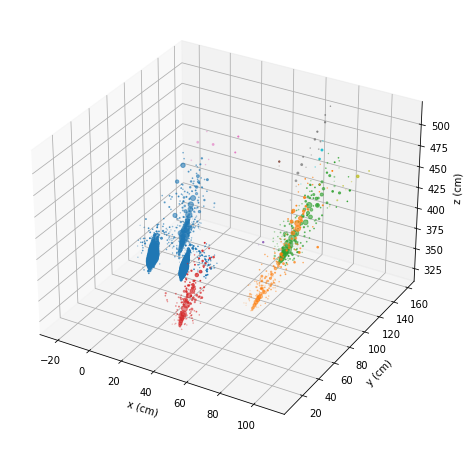

In [63]:
evaluate_remapped(dbscan.labels_)
plot_remapped(tracksters, eid, dbscan.labels_)

eps 16: components: 18, components with energy: 18
Precision: 0.74, Recall: 0.82, F-score: 0.78
Precision: 0.74, Recall: 0.82, F-score: 0.78
eps 17: components: 15, components with energy: 15
Precision: 0.74, Recall: 0.82, F-score: 0.78
Precision: 0.74, Recall: 0.82, F-score: 0.78
eps 18: components: 14, components with energy: 14
Precision: 0.67, Recall: 0.83, F-score: 0.74
Precision: 0.67, Recall: 0.83, F-score: 0.74
eps 19: components: 12, components with energy: 12
Precision: 0.67, Recall: 0.94, F-score: 0.78
Precision: 0.67, Recall: 0.94, F-score: 0.78
eps 20: components: 10, components with energy: 10
Precision: 0.67, Recall: 0.94, F-score: 0.78
Precision: 0.67, Recall: 0.94, F-score: 0.78
eps 21: components: 9, components with energy: 9
Precision: 0.67, Recall: 0.96, F-score: 0.79
Precision: 0.67, Recall: 0.96, F-score: 0.79
eps 22: components: 8, components with energy: 8
Precision: 0.67, Recall: 0.96, F-score: 0.79
Precision: 0.67, Recall: 0.96, F-score: 0.79
eps 23: component

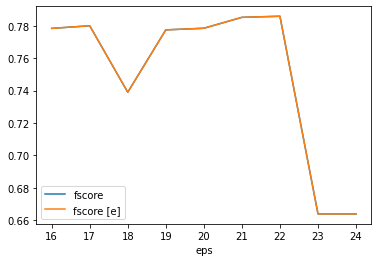

In [12]:
# fine tune the eps
eps_range = np.arange(16, 25)

models = []
models_e = []

for eps in eps_range:
    woe = DBSCAN(eps=eps, min_samples=1).fit(X)
    we = DBSCAN(eps=eps, min_samples=1).fit(X, sample_weight=raw_e)
    print(f"eps {eps}: components: {max(woe.labels_)+1}, components with energy: {max(we.labels_)+1}")

    models.append(evaluate_remapped(woe.labels_)[2])
    models_e.append(evaluate_remapped(we.labels_)[2])

plt.plot(eps_range, models, label='fscore')
plt.plot(eps_range, models_e, label='fscore [e]')
plt.xlabel('eps')
plt.legend()

Tracksters: 9


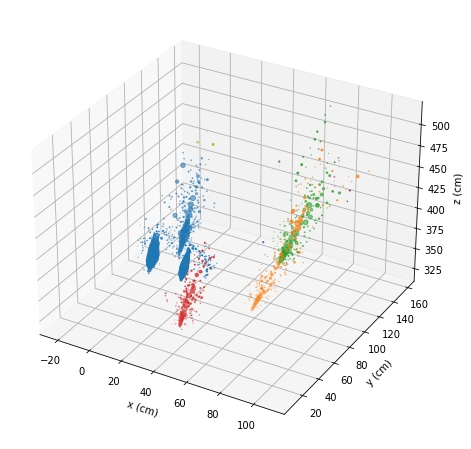

In [57]:
# kmeans on layerclusters
dbscan = DBSCAN(eps=12, min_samples=2).fit(X_vertices)
print("Tracksters:", max(dbscan.labels_)+1)

ri = remap_items_by_label(ak.flatten(t_indexes), dbscan.labels_)
re = remap_items_by_label(ak.flatten(t_energy), dbscan.labels_)
rm = remap_items_by_label(ak.flatten(v_multi), dbscan.labels_)

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), dbscan.labels_)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), dbscan.labels_)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), dbscan.labels_)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

In [59]:
precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.59, Recall: 0.22, F-score: 0.32
